<a href="https://colab.research.google.com/github/yseeker/pytorch-gan/blob/main/conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision.transforms as transforms

from PIL import Image

class CFG:
    n_epoch = 10
    batch_size = 64
    lr = 2e-4
    nch_g = 128
    nch_d = 128
    z_dim = 100
    beta1 = 0.5

In [2]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5, ))
])
dataset = dset.MNIST('./drive/MyDrive/data/', download = True, train = True, transform = transform)
dataloader = DataLoader(dataset = dataset, batch_size=CFG.batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./drive/MyDrive/data/MNIST/raw/train-images-idx3-ubyte.gz to ./drive/MyDrive/data/MNIST/raw




Extracting ./drive/MyDrive/data/MNIST/raw/train-labels-idx1-ubyte.gz to ./drive/MyDrive/data/MNIST/raw




Extracting ./drive/MyDrive/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./drive/MyDrive/data/MNIST/raw




Extracting ./drive/MyDrive/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./drive/MyDrive/data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def save_params(file_path, epoch, netD, netG):
    torch.save(
        netG.state_dict(),
        file_path + '/g_{:04d}.pth'.format(epoch)
    )
    torch.save(
        netD.state_dict(),
        file_path + '/g_{:04d}.pth'.format(epoch)
    )

def get_noise_with_label(noise, labels, device, n_class = 10):
    one_hot_vec = torch.nn.functional.one_hot(labels, num_classes=n_class).view(-1, n_class, 1, 1).to(device)
    concat_noise = torch.cat((noise, one_hot_vec), dim = 1)
    return concat_noise

def get_img_with_label(imgs, labels, device, n_class = 10):
    B, _, H, W = imgs.size()
    one_hot_vec = torch.nn.functional.one_hot(labels, num_classes= n_class).view(-1, n_class, 1, 1)
    one_hot_vec = one_hot_vec.expand(B, n_class, H, W).to(device)
    concat_img = torch.cat((imgs, one_hot_vec), dim = 1)
    return concat_img

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim = 100+10, ngf = 128, nc = 1):
        super().__init__()
        self.convt1 = self.conv_trans_layers(z_dim, 4*ngf, 3, 1, 0)
        self.convt2 = self.conv_trans_layers(4*ngf, 2*ngf, 3, 2, 0)
        self.convt3 = self.conv_trans_layers(2*ngf, ngf, 4, 2, 1)
        self.convt4 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            nn.Tanh()
        )

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size,stride,padding, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return net

    def forward(self, x):
        out = self.convt1(x)
        out = self.convt2(out)
        out = self.convt3(out)
        out = self.convt4(out)
        return out

class Discrimnator(nn.Module):
    def __init__(self, nc = 1+10, ndf = 128):
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf, has_batch_norm = False)
        self.conv2 = self.conv_layers(ndf, 2*ndf)
        self.conv3 = self.conv_layers(2*ndf, 4*ndf, 3, 2, 0)
        self.conv4 = nn.Sequential(
            nn.Conv2d(4*ndf, 1, 3, 1, 0),
            nn.Sigmoid()
        )
    
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1,
                     has_batch_norm = True):
        layers = [
                  nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        ]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        net = nn.Sequential(*layers)
        return net

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        return out

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(z_dim = CFG.z_dim + 10, ngf = CFG.nch_g).to(device)
generator.apply(weights_init)

discriminator = Discrimnator(nc = 1 + 10, ndf = CFG.nch_d).to(device)
discriminator.apply(weights_init)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr = CFG.lr, betas=(CFG.beta1, 0.999), weight_decay = 1e-5)
optimizer_D = optim.Adam(discriminator.parameters(), lr = CFG.lr, betas=(CFG.beta1, 0.999), weight_decay = 1e-5)

model_name = 'CGAN'
f_path_result = './drive/MyDrive/result/{}'.format(model_name)
f_path_params = './drive/MyDrive/result/{}'.format(model_name)

os.makedirs(f_path_result, exist_ok = True)
os.makedirs(f_path_params, exist_ok = True)

In [6]:
def train_one_step(real_imgs_with_label, noise_with_label, labels_valid, labels_fake, labels):
    """Train Discriminator"""
    optimizer_D.zero_grad()
    out_real = discriminator(real_imgs_with_label)
    out_fake = generator(noise_with_label)
    out_fake_with_label = get_img_with_label(out_fake, labels, device)
    output = discriminator(out_fake_with_label.detach())
    real_loss = criterion(output, labels_valid)
    fake_loss = criterion(output, labels_fake)
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    """Train Generator"""
    optimizer_G.zero_grad()
    output = discriminator(out_fake_with_label)
    g_loss = criterion(output, labels_valid)
    g_loss.backward()
    optimizer_G.step()

    return out_fake, g_loss, d_loss

100%|██████████| 938/938 [00:48<00:00, 19.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 0, lossD: 1.109406561968026, lossG: 1.5580517522244057


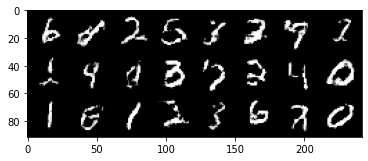

100%|██████████| 938/938 [00:48<00:00, 19.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, lossD: 1.2981441628450014, lossG: 0.9508304363374771


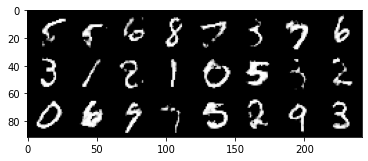

  8%|▊         | 74/938 [00:03<00:44, 19.35it/s]

In [ ]:
lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []
for epoch in range(CFG.n_epoch):
    running_lossD = 0.0
    running_lossG = 0.0
    for i, (real_imgs, labels) in enumerate(tqdm.tqdm(dataloader, position = 0)):
        real_imgs = real_imgs.to(device)
        real_imgs_with_label = get_img_with_label(real_imgs, labels, device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, CFG.z_dim, 1, 1).to(device)
        noise_with_label = get_noise_with_label(noise, labels, device)

        shape = (batch_size, 1, 1, 1)
        labels_real = torch.ones(shape).to(device)
        labels_fake = torch.zeros(shape).to(device)

        """train Discriminator"""
        optimizer_D.zero_grad()
        output = discriminator(real_imgs_with_label)
        lossD_real = criterion(output, labels_real)

        fake_imgs = generator(noise_with_label)
        fake_imgs_with_label = get_img_with_label(fake_imgs, labels, device)
        output = discriminator(fake_imgs_with_label.detach())
        lossD_fake = criterion(output, labels_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        output = discriminator(fake_imgs_with_label)
        lossG = criterion(output, labels_real)
        lossG.backward()
        optimizer_G.step()

        running_lossD += lossD.item()
        running_lossG += lossG.item()
        raw_lossesD.append(lossD.item())
    running_lossD /= len(dataloader)
    running_lossG /= len(dataloader)
    print('epoch: {}, lossD: {}, lossG: {}'.format(epoch, running_lossD, running_lossG))
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    # show fake imgs
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach())
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

    # save imgs and parameters
    vutils.save_image(fake_imgs, f_path_result + '/{}.jpg'.format(epoch))
    save_params(f_path_params, epoch, discriminator, generator)